# Homework 1 - Supervised Deep Learning

##  Regression task

In [1]:
#importing libraries
import pandas as pd
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from scipy.stats import loguniform 
from sklearn.model_selection import KFold
from skorch.callbacks import EarlyStopping
from skorch import NeuralNetRegressor
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import seaborn as sns
from torch.utils.data import TensorDataset, DataLoader

import seaborn as sb 
sb.set_style( "darkgrid")

In [2]:
# Setting the seed or random_state for reproducibility
np.random.seed(123456)
torch.manual_seed(123456)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cpu


### Dataset

In particular, regression is performed on a given dataset consisted of 100 train points and 100 test points. 

##### Loading the dataset

In [3]:
#loading train
train_df = pd.read_csv('regression_dataset/train_data.csv')
#shuffle
np.random.shuffle(train_df.values)
train_df = train_df.values
print( 'Lengt of the train dataset is: ', len(train_df))

#loading test
test_df = pd.read_csv('regression_dataset/test_data.csv')
#shuffle
np.random.shuffle(test_df.values)
test_df = test_df.values
print( 'Lengt of the test dataset is: ', len(test_df))


Lengt of the train dataset is:  100
Lengt of the test dataset is:  100


In [4]:
#Prepare X_train, y_train, X_test, y_test
X_train=train_df[:,0]
y_train=train_df[:,1]

X_test=test_df[:,0]
y_test=test_df[:,1]

#convert to Pytorch tensor
X_train=np.expand_dims(X_train, axis=1)
y_train=np.expand_dims(y_train, axis=1)
X_train=torch.from_numpy(X_train).float()
y_train=torch.from_numpy(y_train).float()

X_test=np.expand_dims(X_test, axis=1)
y_test=np.expand_dims(y_test, axis=1)
X_test=torch.from_numpy(X_test).float()
y_test=torch.from_numpy(y_test).float()

### Setting the network model

It is composed by fully connected layers.

In [5]:
class Net(nn.Module):
    
    def __init__(self, Ni, Nh1, Nh2, No, drop=0.01):
        """
        Ni - Input size
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        No - Output size
        """
        super().__init__()
        
        print('Network initialized')
              
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.dr1 = nn.Dropout(p=drop) #regularization
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        self.out = nn.Linear(in_features=Nh2, out_features=No)
        self.sig = nn.Sigmoid()
        self.relu= nn.ReLU() #helps overcoming vanishing gradient problem
        self.name="Net"
        
        
    def forward(self, x, additional_out=False):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.out(x)  
        return x

In [6]:
# Define the loss function
loss_function = nn.MSELoss()

In [7]:
#Define the early stopping
early_stop = EarlyStopping(
    monitor='valid_loss',
    patience=500,
    threshold=0.0001,
    threshold_mode='rel',
    lower_is_better=True)

#prepare networkso that it can be implementd in the GridSearch module
net = NeuralNetRegressor(
    module=Net,
    device=device, 
    module__Ni= 1,
    module__Nh1 = 32,
    module__Nh2 = 32,
    module__No = 1,
    module__drop = 0.1, 
    max_epochs=3000,
    optimizer = optim.Adam,
    optimizer__lr=0.001,
    optimizer__weight_decay=1e-5, #L2 norm
    criterion=nn.MSELoss,
    callbacks = [early_stop],
    verbose=0
)

## Grid search

In [8]:
#Number of folds
k_folds = 4

#define paramenters to search
parameters = {
    'module__Nh1':[20, 40, 50, 75],
    'module__Nh2': [20, 40, 50, 75],
    "module__drop" : [0.001,0.01,0.1,0.5],
    'max_epochs': [2000],
    'optimizer__lr':[1e-4, 1e-2], 
    'optimizer__weight_decay':[1e-3,1e-4,1e-5],  #L2 norm,
    'optimizer': [optim.SGD, optim.Adam]
}

In [9]:
gs = GridSearchCV(net, parameters, refit=True, cv=k_folds, scoring="neg_mean_squared_error",verbose=10)

In [10]:
gs.fit(X_train, y_train)

Fitting 4 folds for each of 768 candidates, totalling 3072 fits
[CV 1/4; 1/768] START max_epochs=2000, module__Nh1=20, module__Nh2=20, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 1/4; 1/768] END max_epochs=2000, module__Nh1=20, module__Nh2=20, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001; total time=  42.1s
[CV 2/4; 1/768] START max_epochs=2000, module__Nh1=20, module__Nh2=20, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 2/4; 1/768] END max_epochs=2000, module__Nh1=20, module__Nh2=20, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001; total time=  46.9s
[CV 3/4; 1/768] START max_epochs=2000, module__Nh1=20, module__Nh2=20, module__drop=

[CV 4/4; 5/768] END max_epochs=2000, module__Nh1=20, module__Nh2=20, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001; total time=  42.4s
[CV 1/4; 6/768] START max_epochs=2000, module__Nh1=20, module__Nh2=20, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 1/4; 6/768] END max_epochs=2000, module__Nh1=20, module__Nh2=20, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05; total time=  45.6s
[CV 2/4; 6/768] START max_epochs=2000, module__Nh1=20, module__Nh2=20, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 2/4; 6/768] END max_epochs=2000, module__Nh1=20, module__Nh2=20, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optim

[CV 4/4; 10/768] END max_epochs=2000, module__Nh1=20, module__Nh2=20, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.001; total time=   7.6s
[CV 1/4; 11/768] START max_epochs=2000, module__Nh1=20, module__Nh2=20, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 1/4; 11/768] END max_epochs=2000, module__Nh1=20, module__Nh2=20, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001; total time=  16.3s
[CV 2/4; 11/768] START max_epochs=2000, module__Nh1=20, module__Nh2=20, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 2/4; 11/768] END max_epochs=2000, module__Nh1=20, module__Nh2=20, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimize

[CV 4/4; 15/768] END max_epochs=2000, module__Nh1=20, module__Nh2=20, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05; total time=  46.5s
[CV 1/4; 16/768] START max_epochs=2000, module__Nh1=20, module__Nh2=20, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 1/4; 16/768] END max_epochs=2000, module__Nh1=20, module__Nh2=20, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.001; total time=  49.1s
[CV 2/4; 16/768] START max_epochs=2000, module__Nh1=20, module__Nh2=20, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 2/4; 16/768] END max_epochs=2000, module__Nh1=20, module__Nh2=20, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, opti

[CV 4/4; 20/768] END max_epochs=2000, module__Nh1=20, module__Nh2=20, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001; total time=  59.5s
[CV 1/4; 21/768] START max_epochs=2000, module__Nh1=20, module__Nh2=20, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 1/4; 21/768] END max_epochs=2000, module__Nh1=20, module__Nh2=20, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05; total time=  48.6s
[CV 2/4; 21/768] START max_epochs=2000, module__Nh1=20, module__Nh2=20, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 2/4; 21/768] END max_epochs=2000, module__Nh1=20, module__Nh2=20, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimiz

[CV 4/4; 25/768] END max_epochs=2000, module__Nh1=20, module__Nh2=20, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001; total time=  54.6s
[CV 1/4; 26/768] START max_epochs=2000, module__Nh1=20, module__Nh2=20, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 1/4; 26/768] END max_epochs=2000, module__Nh1=20, module__Nh2=20, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001; total time= 1.1min
[CV 2/4; 26/768] START max_epochs=2000, module__Nh1=20, module__Nh2=20, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 2/4; 26/768] END max_epochs=2000, module__Nh1=20, module__Nh2=20, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001

[CV 4/4; 30/768] END max_epochs=2000, module__Nh1=20, module__Nh2=20, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05; total time=  41.5s
[CV 1/4; 31/768] START max_epochs=2000, module__Nh1=20, module__Nh2=20, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 1/4; 31/768] END max_epochs=2000, module__Nh1=20, module__Nh2=20, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001; total time=  42.1s
[CV 2/4; 31/768] START max_epochs=2000, module__Nh1=20, module__Nh2=20, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 2/4; 31/768] END max_epochs=2000, module__Nh1=20, module__Nh2=20, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0

[CV 4/4; 35/768] END max_epochs=2000, module__Nh1=20, module__Nh2=20, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001; total time=  11.5s
[CV 1/4; 36/768] START max_epochs=2000, module__Nh1=20, module__Nh2=20, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 1/4; 36/768] END max_epochs=2000, module__Nh1=20, module__Nh2=20, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05; total time=  19.4s
[CV 2/4; 36/768] START max_epochs=2000, module__Nh1=20, module__Nh2=20, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 2/4; 36/768] END max_epochs=2000, module__Nh1=20, module__Nh2=20, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, 

[CV 4/4; 40/768] END max_epochs=2000, module__Nh1=20, module__Nh2=20, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.001; total time=  55.8s
[CV 1/4; 41/768] START max_epochs=2000, module__Nh1=20, module__Nh2=20, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 1/4; 41/768] END max_epochs=2000, module__Nh1=20, module__Nh2=20, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001; total time=  55.0s
[CV 2/4; 41/768] START max_epochs=2000, module__Nh1=20, module__Nh2=20, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 2/4; 41/768] END max_epochs=2000, module__Nh1=20, module__Nh2=20, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimize

[CV 4/4; 45/768] END max_epochs=2000, module__Nh1=20, module__Nh2=20, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05; total time=  44.7s
[CV 1/4; 46/768] START max_epochs=2000, module__Nh1=20, module__Nh2=20, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 1/4; 46/768] END max_epochs=2000, module__Nh1=20, module__Nh2=20, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.001; total time=   9.4s
[CV 2/4; 46/768] START max_epochs=2000, module__Nh1=20, module__Nh2=20, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 2/4; 46/768] END max_epochs=2000, module__Nh1=20, module__Nh2=20, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01,

[CV 4/4; 50/768] END max_epochs=2000, module__Nh1=20, module__Nh2=40, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001; total time=  45.0s
[CV 1/4; 51/768] START max_epochs=2000, module__Nh1=20, module__Nh2=40, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 1/4; 51/768] END max_epochs=2000, module__Nh1=20, module__Nh2=40, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05; total time=  41.3s
[CV 2/4; 51/768] START max_epochs=2000, module__Nh1=20, module__Nh2=40, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 2/4; 51/768] END max_epochs=2000, module__Nh1=20, module__Nh2=40, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__l

[CV 4/4; 55/768] END max_epochs=2000, module__Nh1=20, module__Nh2=40, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001; total time=  43.7s
[CV 1/4; 56/768] START max_epochs=2000, module__Nh1=20, module__Nh2=40, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 1/4; 56/768] END max_epochs=2000, module__Nh1=20, module__Nh2=40, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001; total time=  42.9s
[CV 2/4; 56/768] START max_epochs=2000, module__Nh1=20, module__Nh2=40, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 2/4; 56/768] END max_epochs=2000, module__Nh1=20, module__Nh2=40, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, 

[CV 4/4; 60/768] END max_epochs=2000, module__Nh1=20, module__Nh2=40, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05; total time=   5.9s
[CV 1/4; 61/768] START max_epochs=2000, module__Nh1=20, module__Nh2=40, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 1/4; 61/768] END max_epochs=2000, module__Nh1=20, module__Nh2=40, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001; total time=  41.7s
[CV 2/4; 61/768] START max_epochs=2000, module__Nh1=20, module__Nh2=40, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 2/4; 61/768] END max_epochs=2000, module__Nh1=20, module__Nh2=40, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0

[CV 4/4; 65/768] END max_epochs=2000, module__Nh1=20, module__Nh2=40, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001; total time=  41.0s
[CV 1/4; 66/768] START max_epochs=2000, module__Nh1=20, module__Nh2=40, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 1/4; 66/768] END max_epochs=2000, module__Nh1=20, module__Nh2=40, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05; total time=  42.8s
[CV 2/4; 66/768] START max_epochs=2000, module__Nh1=20, module__Nh2=40, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 2/4; 66/768] END max_epochs=2000, module__Nh1=20, module__Nh2=40, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optim

[CV 4/4; 70/768] END max_epochs=2000, module__Nh1=20, module__Nh2=40, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.001; total time=   9.5s
[CV 1/4; 71/768] START max_epochs=2000, module__Nh1=20, module__Nh2=40, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 1/4; 71/768] END max_epochs=2000, module__Nh1=20, module__Nh2=40, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001; total time=  10.1s
[CV 2/4; 71/768] START max_epochs=2000, module__Nh1=20, module__Nh2=40, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 2/4; 71/768] END max_epochs=2000, module__Nh1=20, module__Nh2=40, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr

[CV 4/4; 75/768] END max_epochs=2000, module__Nh1=20, module__Nh2=40, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05; total time=  42.0s
[CV 1/4; 76/768] START max_epochs=2000, module__Nh1=20, module__Nh2=40, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 1/4; 76/768] END max_epochs=2000, module__Nh1=20, module__Nh2=40, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.001; total time=  41.0s
[CV 2/4; 76/768] START max_epochs=2000, module__Nh1=20, module__Nh2=40, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 2/4; 76/768] END max_epochs=2000, module__Nh1=20, module__Nh2=40, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer

[CV 4/4; 80/768] END max_epochs=2000, module__Nh1=20, module__Nh2=40, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001; total time=  45.6s
[CV 1/4; 81/768] START max_epochs=2000, module__Nh1=20, module__Nh2=40, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 1/4; 81/768] END max_epochs=2000, module__Nh1=20, module__Nh2=40, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05; total time=  44.5s
[CV 2/4; 81/768] START max_epochs=2000, module__Nh1=20, module__Nh2=40, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 2/4; 81/768] END max_epochs=2000, module__Nh1=20, module__Nh2=40, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__l

[CV 4/4; 85/768] END max_epochs=2000, module__Nh1=20, module__Nh2=40, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001; total time=  42.8s
[CV 1/4; 86/768] START max_epochs=2000, module__Nh1=20, module__Nh2=40, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 1/4; 86/768] END max_epochs=2000, module__Nh1=20, module__Nh2=40, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001; total time=  44.2s
[CV 2/4; 86/768] START max_epochs=2000, module__Nh1=20, module__Nh2=40, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 2/4; 86/768] END max_epochs=2000, module__Nh1=20, module__Nh2=40, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001

[CV 4/4; 90/768] END max_epochs=2000, module__Nh1=20, module__Nh2=40, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05; total time=  48.0s
[CV 1/4; 91/768] START max_epochs=2000, module__Nh1=20, module__Nh2=40, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 1/4; 91/768] END max_epochs=2000, module__Nh1=20, module__Nh2=40, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001; total time=  52.6s
[CV 2/4; 91/768] START max_epochs=2000, module__Nh1=20, module__Nh2=40, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 2/4; 91/768] END max_epochs=2000, module__Nh1=20, module__Nh2=40, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0

[CV 4/4; 95/768] END max_epochs=2000, module__Nh1=20, module__Nh2=40, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001; total time=  12.8s
[CV 1/4; 96/768] START max_epochs=2000, module__Nh1=20, module__Nh2=40, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 1/4; 96/768] END max_epochs=2000, module__Nh1=20, module__Nh2=40, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05; total time=  12.1s
[CV 2/4; 96/768] START max_epochs=2000, module__Nh1=20, module__Nh2=40, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 2/4; 96/768] END max_epochs=2000, module__Nh1=20, module__Nh2=40, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, 

[CV 4/4; 100/768] END max_epochs=2000, module__Nh1=20, module__Nh2=50, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.001; total time=  50.6s
[CV 1/4; 101/768] START max_epochs=2000, module__Nh1=20, module__Nh2=50, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 1/4; 101/768] END max_epochs=2000, module__Nh1=20, module__Nh2=50, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001; total time=  51.2s
[CV 2/4; 101/768] START max_epochs=2000, module__Nh1=20, module__Nh2=50, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 2/4; 101/768] END max_epochs=2000, module__Nh1=20, module__Nh2=50, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr

[CV 3/4; 105/768] END max_epochs=2000, module__Nh1=20, module__Nh2=50, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05; total time=  43.6s
[CV 4/4; 105/768] START max_epochs=2000, module__Nh1=20, module__Nh2=50, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 4/4; 105/768] END max_epochs=2000, module__Nh1=20, module__Nh2=50, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05; total time=  43.2s
[CV 1/4; 106/768] START max_epochs=2000, module__Nh1=20, module__Nh2=50, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 1/4; 106/768] END max_epochs=2000, module__Nh1=20, module__Nh2=50, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, 

[CV 3/4; 110/768] END max_epochs=2000, module__Nh1=20, module__Nh2=50, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001; total time=  43.2s
[CV 4/4; 110/768] START max_epochs=2000, module__Nh1=20, module__Nh2=50, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 4/4; 110/768] END max_epochs=2000, module__Nh1=20, module__Nh2=50, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001; total time=  45.9s
[CV 1/4; 111/768] START max_epochs=2000, module__Nh1=20, module__Nh2=50, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 1/4; 111/768] END max_epochs=2000, module__Nh1=20, module__Nh2=50, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer_

[CV 3/4; 115/768] END max_epochs=2000, module__Nh1=20, module__Nh2=50, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001; total time=  52.4s
[CV 4/4; 115/768] START max_epochs=2000, module__Nh1=20, module__Nh2=50, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 4/4; 115/768] END max_epochs=2000, module__Nh1=20, module__Nh2=50, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001; total time=  52.8s
[CV 1/4; 116/768] START max_epochs=2000, module__Nh1=20, module__Nh2=50, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 1/4; 116/768] END max_epochs=2000, module__Nh1=20, module__Nh2=50, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, op

[CV 3/4; 120/768] END max_epochs=2000, module__Nh1=20, module__Nh2=50, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05; total time=   7.6s
[CV 4/4; 120/768] START max_epochs=2000, module__Nh1=20, module__Nh2=50, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 4/4; 120/768] END max_epochs=2000, module__Nh1=20, module__Nh2=50, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05; total time=   6.2s
[CV 1/4; 121/768] START max_epochs=2000, module__Nh1=20, module__Nh2=50, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 1/4; 121/768] END max_epochs=2000, module__Nh1=20, module__Nh2=50, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0

[CV 3/4; 125/768] END max_epochs=2000, module__Nh1=20, module__Nh2=50, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001; total time=  42.1s
[CV 4/4; 125/768] START max_epochs=2000, module__Nh1=20, module__Nh2=50, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 4/4; 125/768] END max_epochs=2000, module__Nh1=20, module__Nh2=50, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001; total time=  42.6s
[CV 1/4; 126/768] START max_epochs=2000, module__Nh1=20, module__Nh2=50, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 1/4; 126/768] END max_epochs=2000, module__Nh1=20, module__Nh2=50, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, opt

[CV 3/4; 130/768] END max_epochs=2000, module__Nh1=20, module__Nh2=50, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.001; total time=   9.5s
[CV 4/4; 130/768] START max_epochs=2000, module__Nh1=20, module__Nh2=50, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 4/4; 130/768] END max_epochs=2000, module__Nh1=20, module__Nh2=50, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.001; total time=   6.4s
[CV 1/4; 131/768] START max_epochs=2000, module__Nh1=20, module__Nh2=50, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 1/4; 131/768] END max_epochs=2000, module__Nh1=20, module__Nh2=50, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0

[CV 3/4; 135/768] END max_epochs=2000, module__Nh1=20, module__Nh2=50, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05; total time=  41.0s
[CV 4/4; 135/768] START max_epochs=2000, module__Nh1=20, module__Nh2=50, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 4/4; 135/768] END max_epochs=2000, module__Nh1=20, module__Nh2=50, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05; total time=  41.0s
[CV 1/4; 136/768] START max_epochs=2000, module__Nh1=20, module__Nh2=50, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 1/4; 136/768] END max_epochs=2000, module__Nh1=20, module__Nh2=50, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, 

[CV 3/4; 140/768] END max_epochs=2000, module__Nh1=20, module__Nh2=50, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001; total time=  43.2s
[CV 4/4; 140/768] START max_epochs=2000, module__Nh1=20, module__Nh2=50, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 4/4; 140/768] END max_epochs=2000, module__Nh1=20, module__Nh2=50, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001; total time=  41.8s
[CV 1/4; 141/768] START max_epochs=2000, module__Nh1=20, module__Nh2=50, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 1/4; 141/768] END max_epochs=2000, module__Nh1=20, module__Nh2=50, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optim

[CV 3/4; 145/768] END max_epochs=2000, module__Nh1=20, module__Nh2=75, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001; total time=  41.0s
[CV 4/4; 145/768] START max_epochs=2000, module__Nh1=20, module__Nh2=75, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 4/4; 145/768] END max_epochs=2000, module__Nh1=20, module__Nh2=75, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001; total time=  40.9s
[CV 1/4; 146/768] START max_epochs=2000, module__Nh1=20, module__Nh2=75, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 1/4; 146/768] END max_epochs=2000, module__Nh1=20, module__Nh2=75, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimiz

[CV 3/4; 150/768] END max_epochs=2000, module__Nh1=20, module__Nh2=75, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05; total time=  41.3s
[CV 4/4; 150/768] START max_epochs=2000, module__Nh1=20, module__Nh2=75, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 4/4; 150/768] END max_epochs=2000, module__Nh1=20, module__Nh2=75, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05; total time=  40.7s
[CV 1/4; 151/768] START max_epochs=2000, module__Nh1=20, module__Nh2=75, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 1/4; 151/768] END max_epochs=2000, module__Nh1=20, module__Nh2=75, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer_

[CV 2/4; 155/768] END max_epochs=2000, module__Nh1=20, module__Nh2=75, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001; total time=   8.8s
[CV 3/4; 155/768] START max_epochs=2000, module__Nh1=20, module__Nh2=75, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 3/4; 155/768] END max_epochs=2000, module__Nh1=20, module__Nh2=75, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001; total time=  20.4s
[CV 4/4; 155/768] START max_epochs=2000, module__Nh1=20, module__Nh2=75, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 4/4; 155/768] END max_epochs=2000, module__Nh1=20, module__Nh2=75, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, op

[CV 2/4; 160/768] END max_epochs=2000, module__Nh1=20, module__Nh2=75, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.001; total time=  41.0s
[CV 3/4; 160/768] START max_epochs=2000, module__Nh1=20, module__Nh2=75, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 3/4; 160/768] END max_epochs=2000, module__Nh1=20, module__Nh2=75, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.001; total time=  30.2s
[CV 4/4; 160/768] START max_epochs=2000, module__Nh1=20, module__Nh2=75, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 4/4; 160/768] END max_epochs=2000, module__Nh1=20, module__Nh2=75, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, o

[CV 2/4; 165/768] END max_epochs=2000, module__Nh1=20, module__Nh2=75, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05; total time=  42.2s
[CV 3/4; 165/768] START max_epochs=2000, module__Nh1=20, module__Nh2=75, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 3/4; 165/768] END max_epochs=2000, module__Nh1=20, module__Nh2=75, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05; total time=  42.7s
[CV 4/4; 165/768] START max_epochs=2000, module__Nh1=20, module__Nh2=75, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 4/4; 165/768] END max_epochs=2000, module__Nh1=20, module__Nh2=75, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, opt

[CV 2/4; 170/768] END max_epochs=2000, module__Nh1=20, module__Nh2=75, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001; total time=  41.5s
[CV 3/4; 170/768] START max_epochs=2000, module__Nh1=20, module__Nh2=75, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 3/4; 170/768] END max_epochs=2000, module__Nh1=20, module__Nh2=75, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001; total time=  43.3s
[CV 4/4; 170/768] START max_epochs=2000, module__Nh1=20, module__Nh2=75, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 4/4; 170/768] END max_epochs=2000, module__Nh1=20, module__Nh2=75, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=

[CV 2/4; 175/768] END max_epochs=2000, module__Nh1=20, module__Nh2=75, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001; total time=  42.9s
[CV 3/4; 175/768] START max_epochs=2000, module__Nh1=20, module__Nh2=75, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 3/4; 175/768] END max_epochs=2000, module__Nh1=20, module__Nh2=75, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001; total time=  42.4s
[CV 4/4; 175/768] START max_epochs=2000, module__Nh1=20, module__Nh2=75, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 4/4; 175/768] END max_epochs=2000, module__Nh1=20, module__Nh2=75, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimize

[CV 2/4; 180/768] END max_epochs=2000, module__Nh1=20, module__Nh2=75, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05; total time=  28.7s
[CV 3/4; 180/768] START max_epochs=2000, module__Nh1=20, module__Nh2=75, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 3/4; 180/768] END max_epochs=2000, module__Nh1=20, module__Nh2=75, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05; total time=  32.4s
[CV 4/4; 180/768] START max_epochs=2000, module__Nh1=20, module__Nh2=75, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 4/4; 180/768] END max_epochs=2000, module__Nh1=20, module__Nh2=75, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.

[CV 2/4; 185/768] END max_epochs=2000, module__Nh1=20, module__Nh2=75, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001; total time=  40.8s
[CV 3/4; 185/768] START max_epochs=2000, module__Nh1=20, module__Nh2=75, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 3/4; 185/768] END max_epochs=2000, module__Nh1=20, module__Nh2=75, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001; total time=  40.0s
[CV 4/4; 185/768] START max_epochs=2000, module__Nh1=20, module__Nh2=75, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 4/4; 185/768] END max_epochs=2000, module__Nh1=20, module__Nh2=75, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, op

[CV 2/4; 190/768] END max_epochs=2000, module__Nh1=20, module__Nh2=75, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.001; total time=   5.9s
[CV 3/4; 190/768] START max_epochs=2000, module__Nh1=20, module__Nh2=75, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 3/4; 190/768] END max_epochs=2000, module__Nh1=20, module__Nh2=75, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.001; total time=  30.6s
[CV 4/4; 190/768] START max_epochs=2000, module__Nh1=20, module__Nh2=75, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 4/4; 190/768] END max_epochs=2000, module__Nh1=20, module__Nh2=75, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.

[CV 2/4; 195/768] END max_epochs=2000, module__Nh1=40, module__Nh2=20, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05; total time=  41.1s
[CV 3/4; 195/768] START max_epochs=2000, module__Nh1=40, module__Nh2=20, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 3/4; 195/768] END max_epochs=2000, module__Nh1=40, module__Nh2=20, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05; total time=  41.2s
[CV 4/4; 195/768] START max_epochs=2000, module__Nh1=40, module__Nh2=20, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 4/4; 195/768] END max_epochs=2000, module__Nh1=40, module__Nh2=20, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimize

[CV 2/4; 200/768] END max_epochs=2000, module__Nh1=40, module__Nh2=20, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001; total time=  42.1s
[CV 3/4; 200/768] START max_epochs=2000, module__Nh1=40, module__Nh2=20, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 3/4; 200/768] END max_epochs=2000, module__Nh1=40, module__Nh2=20, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001; total time=  42.3s
[CV 4/4; 200/768] START max_epochs=2000, module__Nh1=40, module__Nh2=20, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 4/4; 200/768] END max_epochs=2000, module__Nh1=40, module__Nh2=20, module__drop=0.001, optimizer=<class 'torch.optim.adam.Ad

[CV 1/4; 205/768] END max_epochs=2000, module__Nh1=40, module__Nh2=20, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001; total time=  40.6s
[CV 2/4; 205/768] START max_epochs=2000, module__Nh1=40, module__Nh2=20, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 2/4; 205/768] END max_epochs=2000, module__Nh1=40, module__Nh2=20, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001; total time=  42.3s
[CV 3/4; 205/768] START max_epochs=2000, module__Nh1=40, module__Nh2=20, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 3/4; 205/768] END max_epochs=2000, module__Nh1=40, module__Nh2=20, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr

[CV 1/4; 210/768] END max_epochs=2000, module__Nh1=40, module__Nh2=20, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05; total time=  41.4s
[CV 2/4; 210/768] START max_epochs=2000, module__Nh1=40, module__Nh2=20, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 2/4; 210/768] END max_epochs=2000, module__Nh1=40, module__Nh2=20, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05; total time=  41.1s
[CV 3/4; 210/768] START max_epochs=2000, module__Nh1=40, module__Nh2=20, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 3/4; 210/768] END max_epochs=2000, module__Nh1=40, module__Nh2=20, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, o

[CV 1/4; 215/768] END max_epochs=2000, module__Nh1=40, module__Nh2=20, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001; total time=  14.0s
[CV 2/4; 215/768] START max_epochs=2000, module__Nh1=40, module__Nh2=20, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 2/4; 215/768] END max_epochs=2000, module__Nh1=40, module__Nh2=20, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001; total time=   9.5s
[CV 3/4; 215/768] START max_epochs=2000, module__Nh1=40, module__Nh2=20, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 3/4; 215/768] END max_epochs=2000, module__Nh1=40, module__Nh2=20, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimiz

[CV 1/4; 220/768] END max_epochs=2000, module__Nh1=40, module__Nh2=20, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.001; total time=  52.7s
[CV 2/4; 220/768] START max_epochs=2000, module__Nh1=40, module__Nh2=20, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 2/4; 220/768] END max_epochs=2000, module__Nh1=40, module__Nh2=20, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.001; total time=  53.2s
[CV 3/4; 220/768] START max_epochs=2000, module__Nh1=40, module__Nh2=20, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 3/4; 220/768] END max_epochs=2000, module__Nh1=40, module__Nh2=20, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimi

[CV 1/4; 225/768] END max_epochs=2000, module__Nh1=40, module__Nh2=20, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05; total time= 1.1min
[CV 2/4; 225/768] START max_epochs=2000, module__Nh1=40, module__Nh2=20, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 2/4; 225/768] END max_epochs=2000, module__Nh1=40, module__Nh2=20, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05; total time= 1.0min
[CV 3/4; 225/768] START max_epochs=2000, module__Nh1=40, module__Nh2=20, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 3/4; 225/768] END max_epochs=2000, module__Nh1=40, module__Nh2=20, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimize

[CV 1/4; 230/768] END max_epochs=2000, module__Nh1=40, module__Nh2=20, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001; total time=  55.9s
[CV 2/4; 230/768] START max_epochs=2000, module__Nh1=40, module__Nh2=20, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 2/4; 230/768] END max_epochs=2000, module__Nh1=40, module__Nh2=20, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001; total time=  56.0s
[CV 3/4; 230/768] START max_epochs=2000, module__Nh1=40, module__Nh2=20, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 3/4; 230/768] END max_epochs=2000, module__Nh1=40, module__Nh2=20, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=

[CV 1/4; 235/768] END max_epochs=2000, module__Nh1=40, module__Nh2=20, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001; total time=  58.4s
[CV 2/4; 235/768] START max_epochs=2000, module__Nh1=40, module__Nh2=20, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 2/4; 235/768] END max_epochs=2000, module__Nh1=40, module__Nh2=20, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001; total time=  59.1s
[CV 3/4; 235/768] START max_epochs=2000, module__Nh1=40, module__Nh2=20, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 3/4; 235/768] END max_epochs=2000, module__Nh1=40, module__Nh2=20, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimize

[CV 1/4; 240/768] END max_epochs=2000, module__Nh1=40, module__Nh2=20, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05; total time=  21.1s
[CV 2/4; 240/768] START max_epochs=2000, module__Nh1=40, module__Nh2=20, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 2/4; 240/768] END max_epochs=2000, module__Nh1=40, module__Nh2=20, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05; total time=  15.5s
[CV 3/4; 240/768] START max_epochs=2000, module__Nh1=40, module__Nh2=20, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 3/4; 240/768] END max_epochs=2000, module__Nh1=40, module__Nh2=20, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.

[CV 1/4; 245/768] END max_epochs=2000, module__Nh1=40, module__Nh2=40, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001; total time= 1.0min
[CV 2/4; 245/768] START max_epochs=2000, module__Nh1=40, module__Nh2=40, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 2/4; 245/768] END max_epochs=2000, module__Nh1=40, module__Nh2=40, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001; total time= 1.0min
[CV 3/4; 245/768] START max_epochs=2000, module__Nh1=40, module__Nh2=40, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 3/4; 245/768] END max_epochs=2000, module__Nh1=40, module__Nh2=40, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__l

[CV 4/4; 249/768] END max_epochs=2000, module__Nh1=40, module__Nh2=40, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05; total time= 1.1min
[CV 1/4; 250/768] START max_epochs=2000, module__Nh1=40, module__Nh2=40, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 1/4; 250/768] END max_epochs=2000, module__Nh1=40, module__Nh2=40, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.001; total time=  20.5s
[CV 2/4; 250/768] START max_epochs=2000, module__Nh1=40, module__Nh2=40, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 2/4; 250/768] END max_epochs=2000, module__Nh1=40, module__Nh2=40, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, opti

[CV 4/4; 254/768] END max_epochs=2000, module__Nh1=40, module__Nh2=40, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001; total time= 1.0min
[CV 1/4; 255/768] START max_epochs=2000, module__Nh1=40, module__Nh2=40, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 1/4; 255/768] END max_epochs=2000, module__Nh1=40, module__Nh2=40, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05; total time= 1.0min
[CV 2/4; 255/768] START max_epochs=2000, module__Nh1=40, module__Nh2=40, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 2/4; 255/768] END max_epochs=2000, module__Nh1=40, module__Nh2=40, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__l

[CV 4/4; 259/768] END max_epochs=2000, module__Nh1=40, module__Nh2=40, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001; total time= 1.0min
[CV 1/4; 260/768] START max_epochs=2000, module__Nh1=40, module__Nh2=40, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 1/4; 260/768] END max_epochs=2000, module__Nh1=40, module__Nh2=40, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001; total time= 1.0min
[CV 2/4; 260/768] START max_epochs=2000, module__Nh1=40, module__Nh2=40, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 2/4; 260/768] END max_epochs=2000, module__Nh1=40, module__Nh2=40, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, 

[CV 4/4; 264/768] END max_epochs=2000, module__Nh1=40, module__Nh2=40, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05; total time=   5.9s
[CV 1/4; 265/768] START max_epochs=2000, module__Nh1=40, module__Nh2=40, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 1/4; 265/768] END max_epochs=2000, module__Nh1=40, module__Nh2=40, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001; total time=  40.6s
[CV 2/4; 265/768] START max_epochs=2000, module__Nh1=40, module__Nh2=40, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 2/4; 265/768] END max_epochs=2000, module__Nh1=40, module__Nh2=40, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0

[CV 4/4; 269/768] END max_epochs=2000, module__Nh1=40, module__Nh2=40, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001; total time=  40.8s
[CV 1/4; 270/768] START max_epochs=2000, module__Nh1=40, module__Nh2=40, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 1/4; 270/768] END max_epochs=2000, module__Nh1=40, module__Nh2=40, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05; total time=  39.5s
[CV 2/4; 270/768] START max_epochs=2000, module__Nh1=40, module__Nh2=40, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 2/4; 270/768] END max_epochs=2000, module__Nh1=40, module__Nh2=40, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optim

[CV 4/4; 274/768] END max_epochs=2000, module__Nh1=40, module__Nh2=40, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.001; total time=   6.7s
[CV 1/4; 275/768] START max_epochs=2000, module__Nh1=40, module__Nh2=40, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 1/4; 275/768] END max_epochs=2000, module__Nh1=40, module__Nh2=40, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001; total time=  12.4s
[CV 2/4; 275/768] START max_epochs=2000, module__Nh1=40, module__Nh2=40, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 2/4; 275/768] END max_epochs=2000, module__Nh1=40, module__Nh2=40, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr

[CV 4/4; 279/768] END max_epochs=2000, module__Nh1=40, module__Nh2=40, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05; total time=  41.3s
[CV 1/4; 280/768] START max_epochs=2000, module__Nh1=40, module__Nh2=40, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 1/4; 280/768] END max_epochs=2000, module__Nh1=40, module__Nh2=40, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.001; total time=  40.5s
[CV 2/4; 280/768] START max_epochs=2000, module__Nh1=40, module__Nh2=40, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 2/4; 280/768] END max_epochs=2000, module__Nh1=40, module__Nh2=40, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, opti

[CV 4/4; 284/768] END max_epochs=2000, module__Nh1=40, module__Nh2=40, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001; total time=  46.5s
[CV 1/4; 285/768] START max_epochs=2000, module__Nh1=40, module__Nh2=40, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 1/4; 285/768] END max_epochs=2000, module__Nh1=40, module__Nh2=40, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05; total time=  45.1s
[CV 2/4; 285/768] START max_epochs=2000, module__Nh1=40, module__Nh2=40, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 2/4; 285/768] END max_epochs=2000, module__Nh1=40, module__Nh2=40, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimiz

[CV 4/4; 289/768] END max_epochs=2000, module__Nh1=40, module__Nh2=50, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001; total time=  42.4s
[CV 1/4; 290/768] START max_epochs=2000, module__Nh1=40, module__Nh2=50, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 1/4; 290/768] END max_epochs=2000, module__Nh1=40, module__Nh2=50, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001; total time=  41.6s
[CV 2/4; 290/768] START max_epochs=2000, module__Nh1=40, module__Nh2=50, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 2/4; 290/768] END max_epochs=2000, module__Nh1=40, module__Nh2=50, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optim

[CV 4/4; 294/768] END max_epochs=2000, module__Nh1=40, module__Nh2=50, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05; total time=  41.2s
[CV 1/4; 295/768] START max_epochs=2000, module__Nh1=40, module__Nh2=50, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 1/4; 295/768] END max_epochs=2000, module__Nh1=40, module__Nh2=50, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001; total time=  43.6s
[CV 2/4; 295/768] START max_epochs=2000, module__Nh1=40, module__Nh2=50, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 2/4; 295/768] END max_epochs=2000, module__Nh1=40, module__Nh2=50, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, op

[CV 3/4; 299/768] END max_epochs=2000, module__Nh1=40, module__Nh2=50, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001; total time=   6.7s
[CV 4/4; 299/768] START max_epochs=2000, module__Nh1=40, module__Nh2=50, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 4/4; 299/768] END max_epochs=2000, module__Nh1=40, module__Nh2=50, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001; total time=   6.7s
[CV 1/4; 300/768] START max_epochs=2000, module__Nh1=40, module__Nh2=50, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 1/4; 300/768] END max_epochs=2000, module__Nh1=40, module__Nh2=50, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, opt

[CV 3/4; 304/768] END max_epochs=2000, module__Nh1=40, module__Nh2=50, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.001; total time=  42.2s
[CV 4/4; 304/768] START max_epochs=2000, module__Nh1=40, module__Nh2=50, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 4/4; 304/768] END max_epochs=2000, module__Nh1=40, module__Nh2=50, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.001; total time=  41.2s
[CV 1/4; 305/768] START max_epochs=2000, module__Nh1=40, module__Nh2=50, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 1/4; 305/768] END max_epochs=2000, module__Nh1=40, module__Nh2=50, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, 

[CV 3/4; 309/768] END max_epochs=2000, module__Nh1=40, module__Nh2=50, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05; total time=  42.9s
[CV 4/4; 309/768] START max_epochs=2000, module__Nh1=40, module__Nh2=50, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 4/4; 309/768] END max_epochs=2000, module__Nh1=40, module__Nh2=50, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05; total time=  44.1s
[CV 1/4; 310/768] START max_epochs=2000, module__Nh1=40, module__Nh2=50, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 1/4; 310/768] END max_epochs=2000, module__Nh1=40, module__Nh2=50, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optim

[CV 3/4; 314/768] END max_epochs=2000, module__Nh1=40, module__Nh2=50, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001; total time=  41.7s
[CV 4/4; 314/768] START max_epochs=2000, module__Nh1=40, module__Nh2=50, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 4/4; 314/768] END max_epochs=2000, module__Nh1=40, module__Nh2=50, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001; total time=  42.0s
[CV 1/4; 315/768] START max_epochs=2000, module__Nh1=40, module__Nh2=50, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 1/4; 315/768] END max_epochs=2000, module__Nh1=40, module__Nh2=50, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0

[CV 3/4; 319/768] END max_epochs=2000, module__Nh1=40, module__Nh2=50, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001; total time=  43.7s
[CV 4/4; 319/768] START max_epochs=2000, module__Nh1=40, module__Nh2=50, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 4/4; 319/768] END max_epochs=2000, module__Nh1=40, module__Nh2=50, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001; total time=  42.9s
[CV 1/4; 320/768] START max_epochs=2000, module__Nh1=40, module__Nh2=50, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 1/4; 320/768] END max_epochs=2000, module__Nh1=40, module__Nh2=50, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimiz

[CV 3/4; 324/768] END max_epochs=2000, module__Nh1=40, module__Nh2=50, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05; total time=  19.9s
[CV 4/4; 324/768] START max_epochs=2000, module__Nh1=40, module__Nh2=50, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 4/4; 324/768] END max_epochs=2000, module__Nh1=40, module__Nh2=50, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05; total time=   6.5s
[CV 1/4; 325/768] START max_epochs=2000, module__Nh1=40, module__Nh2=50, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 1/4; 325/768] END max_epochs=2000, module__Nh1=40, module__Nh2=50, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.00

[CV 3/4; 329/768] END max_epochs=2000, module__Nh1=40, module__Nh2=50, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001; total time=  41.5s
[CV 4/4; 329/768] START max_epochs=2000, module__Nh1=40, module__Nh2=50, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 4/4; 329/768] END max_epochs=2000, module__Nh1=40, module__Nh2=50, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001; total time=  41.4s
[CV 1/4; 330/768] START max_epochs=2000, module__Nh1=40, module__Nh2=50, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 1/4; 330/768] END max_epochs=2000, module__Nh1=40, module__Nh2=50, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, opt

[CV 3/4; 334/768] END max_epochs=2000, module__Nh1=40, module__Nh2=50, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.001; total time=  21.1s
[CV 4/4; 334/768] START max_epochs=2000, module__Nh1=40, module__Nh2=50, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 4/4; 334/768] END max_epochs=2000, module__Nh1=40, module__Nh2=50, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.001; total time=   6.3s
[CV 1/4; 335/768] START max_epochs=2000, module__Nh1=40, module__Nh2=50, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 1/4; 335/768] END max_epochs=2000, module__Nh1=40, module__Nh2=50, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0

[CV 3/4; 339/768] END max_epochs=2000, module__Nh1=40, module__Nh2=75, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05; total time=  42.4s
[CV 4/4; 339/768] START max_epochs=2000, module__Nh1=40, module__Nh2=75, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 4/4; 339/768] END max_epochs=2000, module__Nh1=40, module__Nh2=75, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05; total time=  41.5s
[CV 1/4; 340/768] START max_epochs=2000, module__Nh1=40, module__Nh2=75, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 1/4; 340/768] END max_epochs=2000, module__Nh1=40, module__Nh2=75, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer_

[CV 3/4; 344/768] END max_epochs=2000, module__Nh1=40, module__Nh2=75, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001; total time=  43.4s
[CV 4/4; 344/768] START max_epochs=2000, module__Nh1=40, module__Nh2=75, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 4/4; 344/768] END max_epochs=2000, module__Nh1=40, module__Nh2=75, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001; total time=  43.4s
[CV 1/4; 345/768] START max_epochs=2000, module__Nh1=40, module__Nh2=75, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 1/4; 345/768] END max_epochs=2000, module__Nh1=40, module__Nh2=75, module__drop=0.001, optimizer=<class 'torch.optim.adam.Ada

[CV 2/4; 349/768] END max_epochs=2000, module__Nh1=40, module__Nh2=75, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001; total time=  43.0s
[CV 3/4; 349/768] START max_epochs=2000, module__Nh1=40, module__Nh2=75, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 3/4; 349/768] END max_epochs=2000, module__Nh1=40, module__Nh2=75, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001; total time=  42.5s
[CV 4/4; 349/768] START max_epochs=2000, module__Nh1=40, module__Nh2=75, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 4/4; 349/768] END max_epochs=2000, module__Nh1=40, module__Nh2=75, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr

[CV 2/4; 354/768] END max_epochs=2000, module__Nh1=40, module__Nh2=75, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05; total time=  40.7s
[CV 3/4; 354/768] START max_epochs=2000, module__Nh1=40, module__Nh2=75, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 3/4; 354/768] END max_epochs=2000, module__Nh1=40, module__Nh2=75, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05; total time=  40.7s
[CV 4/4; 354/768] START max_epochs=2000, module__Nh1=40, module__Nh2=75, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 4/4; 354/768] END max_epochs=2000, module__Nh1=40, module__Nh2=75, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, o

[CV 2/4; 359/768] END max_epochs=2000, module__Nh1=40, module__Nh2=75, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001; total time=   6.4s
[CV 3/4; 359/768] START max_epochs=2000, module__Nh1=40, module__Nh2=75, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 3/4; 359/768] END max_epochs=2000, module__Nh1=40, module__Nh2=75, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001; total time=  20.3s
[CV 4/4; 359/768] START max_epochs=2000, module__Nh1=40, module__Nh2=75, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 4/4; 359/768] END max_epochs=2000, module__Nh1=40, module__Nh2=75, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimiz

[CV 2/4; 364/768] END max_epochs=2000, module__Nh1=40, module__Nh2=75, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.001; total time=  34.3s
[CV 3/4; 364/768] START max_epochs=2000, module__Nh1=40, module__Nh2=75, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 3/4; 364/768] END max_epochs=2000, module__Nh1=40, module__Nh2=75, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.001; total time=  42.6s
[CV 4/4; 364/768] START max_epochs=2000, module__Nh1=40, module__Nh2=75, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 4/4; 364/768] END max_epochs=2000, module__Nh1=40, module__Nh2=75, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimi

[CV 2/4; 369/768] END max_epochs=2000, module__Nh1=40, module__Nh2=75, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05; total time=  43.8s
[CV 3/4; 369/768] START max_epochs=2000, module__Nh1=40, module__Nh2=75, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 3/4; 369/768] END max_epochs=2000, module__Nh1=40, module__Nh2=75, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05; total time=  44.3s
[CV 4/4; 369/768] START max_epochs=2000, module__Nh1=40, module__Nh2=75, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 4/4; 369/768] END max_epochs=2000, module__Nh1=40, module__Nh2=75, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimize

[CV 2/4; 374/768] END max_epochs=2000, module__Nh1=40, module__Nh2=75, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001; total time=  42.2s
[CV 3/4; 374/768] START max_epochs=2000, module__Nh1=40, module__Nh2=75, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 3/4; 374/768] END max_epochs=2000, module__Nh1=40, module__Nh2=75, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001; total time=  42.3s
[CV 4/4; 374/768] START max_epochs=2000, module__Nh1=40, module__Nh2=75, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 4/4; 374/768] END max_epochs=2000, module__Nh1=40, module__Nh2=75, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=

[CV 2/4; 379/768] END max_epochs=2000, module__Nh1=40, module__Nh2=75, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001; total time=  44.2s
[CV 3/4; 379/768] START max_epochs=2000, module__Nh1=40, module__Nh2=75, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 3/4; 379/768] END max_epochs=2000, module__Nh1=40, module__Nh2=75, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001; total time=  43.1s
[CV 4/4; 379/768] START max_epochs=2000, module__Nh1=40, module__Nh2=75, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 4/4; 379/768] END max_epochs=2000, module__Nh1=40, module__Nh2=75, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimize

[CV 2/4; 384/768] END max_epochs=2000, module__Nh1=40, module__Nh2=75, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05; total time=  17.2s
[CV 3/4; 384/768] START max_epochs=2000, module__Nh1=40, module__Nh2=75, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 3/4; 384/768] END max_epochs=2000, module__Nh1=40, module__Nh2=75, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05; total time=  43.0s
[CV 4/4; 384/768] START max_epochs=2000, module__Nh1=40, module__Nh2=75, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 4/4; 384/768] END max_epochs=2000, module__Nh1=40, module__Nh2=75, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.

[CV 2/4; 389/768] END max_epochs=2000, module__Nh1=50, module__Nh2=20, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001; total time=  41.2s
[CV 3/4; 389/768] START max_epochs=2000, module__Nh1=50, module__Nh2=20, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 3/4; 389/768] END max_epochs=2000, module__Nh1=50, module__Nh2=20, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001; total time=  41.1s
[CV 4/4; 389/768] START max_epochs=2000, module__Nh1=50, module__Nh2=20, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 4/4; 389/768] END max_epochs=2000, module__Nh1=50, module__Nh2=20, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__l

[CV 1/4; 394/768] END max_epochs=2000, module__Nh1=50, module__Nh2=20, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.001; total time=  15.3s
[CV 2/4; 394/768] START max_epochs=2000, module__Nh1=50, module__Nh2=20, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 2/4; 394/768] END max_epochs=2000, module__Nh1=50, module__Nh2=20, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.001; total time=   9.4s
[CV 3/4; 394/768] START max_epochs=2000, module__Nh1=50, module__Nh2=20, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 3/4; 394/768] END max_epochs=2000, module__Nh1=50, module__Nh2=20, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimi

[CV 1/4; 399/768] END max_epochs=2000, module__Nh1=50, module__Nh2=20, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05; total time=  41.7s
[CV 2/4; 399/768] START max_epochs=2000, module__Nh1=50, module__Nh2=20, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 2/4; 399/768] END max_epochs=2000, module__Nh1=50, module__Nh2=20, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05; total time=  41.7s
[CV 3/4; 399/768] START max_epochs=2000, module__Nh1=50, module__Nh2=20, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 3/4; 399/768] END max_epochs=2000, module__Nh1=50, module__Nh2=20, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr

[CV 1/4; 404/768] END max_epochs=2000, module__Nh1=50, module__Nh2=20, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001; total time=  43.5s
[CV 2/4; 404/768] START max_epochs=2000, module__Nh1=50, module__Nh2=20, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 2/4; 404/768] END max_epochs=2000, module__Nh1=50, module__Nh2=20, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001; total time=  42.8s
[CV 3/4; 404/768] START max_epochs=2000, module__Nh1=50, module__Nh2=20, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 3/4; 404/768] END max_epochs=2000, module__Nh1=50, module__Nh2=20, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>,

[CV 1/4; 409/768] END max_epochs=2000, module__Nh1=50, module__Nh2=20, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001; total time=  42.2s
[CV 2/4; 409/768] START max_epochs=2000, module__Nh1=50, module__Nh2=20, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 2/4; 409/768] END max_epochs=2000, module__Nh1=50, module__Nh2=20, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001; total time=  42.4s
[CV 3/4; 409/768] START max_epochs=2000, module__Nh1=50, module__Nh2=20, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 3/4; 409/768] END max_epochs=2000, module__Nh1=50, module__Nh2=20, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.00

[CV 1/4; 414/768] END max_epochs=2000, module__Nh1=50, module__Nh2=20, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05; total time=  41.4s
[CV 2/4; 414/768] START max_epochs=2000, module__Nh1=50, module__Nh2=20, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 2/4; 414/768] END max_epochs=2000, module__Nh1=50, module__Nh2=20, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05; total time=  41.4s
[CV 3/4; 414/768] START max_epochs=2000, module__Nh1=50, module__Nh2=20, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 3/4; 414/768] END max_epochs=2000, module__Nh1=50, module__Nh2=20, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimi

[CV 1/4; 419/768] END max_epochs=2000, module__Nh1=50, module__Nh2=20, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001; total time=  11.4s
[CV 2/4; 419/768] START max_epochs=2000, module__Nh1=50, module__Nh2=20, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 2/4; 419/768] END max_epochs=2000, module__Nh1=50, module__Nh2=20, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001; total time=  43.1s
[CV 3/4; 419/768] START max_epochs=2000, module__Nh1=50, module__Nh2=20, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 3/4; 419/768] END max_epochs=2000, module__Nh1=50, module__Nh2=20, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__l

[CV 1/4; 424/768] END max_epochs=2000, module__Nh1=50, module__Nh2=20, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.001; total time=  41.2s
[CV 2/4; 424/768] START max_epochs=2000, module__Nh1=50, module__Nh2=20, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 2/4; 424/768] END max_epochs=2000, module__Nh1=50, module__Nh2=20, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.001; total time=  41.6s
[CV 3/4; 424/768] START max_epochs=2000, module__Nh1=50, module__Nh2=20, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 3/4; 424/768] END max_epochs=2000, module__Nh1=50, module__Nh2=20, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimi

[CV 1/4; 429/768] END max_epochs=2000, module__Nh1=50, module__Nh2=20, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05; total time=  43.4s
[CV 2/4; 429/768] START max_epochs=2000, module__Nh1=50, module__Nh2=20, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 2/4; 429/768] END max_epochs=2000, module__Nh1=50, module__Nh2=20, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05; total time=  44.0s
[CV 3/4; 429/768] START max_epochs=2000, module__Nh1=50, module__Nh2=20, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 3/4; 429/768] END max_epochs=2000, module__Nh1=50, module__Nh2=20, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimize

[CV 1/4; 434/768] END max_epochs=2000, module__Nh1=50, module__Nh2=40, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001; total time=  42.0s
[CV 2/4; 434/768] START max_epochs=2000, module__Nh1=50, module__Nh2=40, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 2/4; 434/768] END max_epochs=2000, module__Nh1=50, module__Nh2=40, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001; total time=  42.6s
[CV 3/4; 434/768] START max_epochs=2000, module__Nh1=50, module__Nh2=40, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 3/4; 434/768] END max_epochs=2000, module__Nh1=50, module__Nh2=40, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, opti

[CV 1/4; 439/768] END max_epochs=2000, module__Nh1=50, module__Nh2=40, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001; total time=  43.2s
[CV 2/4; 439/768] START max_epochs=2000, module__Nh1=50, module__Nh2=40, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 2/4; 439/768] END max_epochs=2000, module__Nh1=50, module__Nh2=40, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001; total time=  43.1s
[CV 3/4; 439/768] START max_epochs=2000, module__Nh1=50, module__Nh2=40, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 3/4; 439/768] END max_epochs=2000, module__Nh1=50, module__Nh2=40, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>

[CV 4/4; 443/768] END max_epochs=2000, module__Nh1=50, module__Nh2=40, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001; total time=   9.5s
[CV 1/4; 444/768] START max_epochs=2000, module__Nh1=50, module__Nh2=40, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 1/4; 444/768] END max_epochs=2000, module__Nh1=50, module__Nh2=40, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05; total time=  20.5s
[CV 2/4; 444/768] START max_epochs=2000, module__Nh1=50, module__Nh2=40, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 2/4; 444/768] END max_epochs=2000, module__Nh1=50, module__Nh2=40, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optim

[CV 4/4; 448/768] END max_epochs=2000, module__Nh1=50, module__Nh2=40, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.001; total time=  42.7s
[CV 1/4; 449/768] START max_epochs=2000, module__Nh1=50, module__Nh2=40, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 1/4; 449/768] END max_epochs=2000, module__Nh1=50, module__Nh2=40, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001; total time=  42.5s
[CV 2/4; 449/768] START max_epochs=2000, module__Nh1=50, module__Nh2=40, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 2/4; 449/768] END max_epochs=2000, module__Nh1=50, module__Nh2=40, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01

[CV 4/4; 453/768] END max_epochs=2000, module__Nh1=50, module__Nh2=40, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05; total time=  43.1s
[CV 1/4; 454/768] START max_epochs=2000, module__Nh1=50, module__Nh2=40, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 1/4; 454/768] END max_epochs=2000, module__Nh1=50, module__Nh2=40, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.001; total time=  11.4s
[CV 2/4; 454/768] START max_epochs=2000, module__Nh1=50, module__Nh2=40, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 2/4; 454/768] END max_epochs=2000, module__Nh1=50, module__Nh2=40, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer

[CV 4/4; 458/768] END max_epochs=2000, module__Nh1=50, module__Nh2=40, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001; total time=  42.1s
[CV 1/4; 459/768] START max_epochs=2000, module__Nh1=50, module__Nh2=40, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 1/4; 459/768] END max_epochs=2000, module__Nh1=50, module__Nh2=40, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05; total time=  42.2s
[CV 2/4; 459/768] START max_epochs=2000, module__Nh1=50, module__Nh2=40, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 2/4; 459/768] END max_epochs=2000, module__Nh1=50, module__Nh2=40, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0

[CV 4/4; 463/768] END max_epochs=2000, module__Nh1=50, module__Nh2=40, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001; total time=  43.2s
[CV 1/4; 464/768] START max_epochs=2000, module__Nh1=50, module__Nh2=40, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 1/4; 464/768] END max_epochs=2000, module__Nh1=50, module__Nh2=40, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001; total time=  43.7s
[CV 2/4; 464/768] START max_epochs=2000, module__Nh1=50, module__Nh2=40, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 2/4; 464/768] END max_epochs=2000, module__Nh1=50, module__Nh2=40, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optim

[CV 4/4; 468/768] END max_epochs=2000, module__Nh1=50, module__Nh2=40, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05; total time=   6.9s
[CV 1/4; 469/768] START max_epochs=2000, module__Nh1=50, module__Nh2=40, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 1/4; 469/768] END max_epochs=2000, module__Nh1=50, module__Nh2=40, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001; total time=  42.9s
[CV 2/4; 469/768] START max_epochs=2000, module__Nh1=50, module__Nh2=40, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 2/4; 469/768] END max_epochs=2000, module__Nh1=50, module__Nh2=40, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.00

[CV 4/4; 473/768] END max_epochs=2000, module__Nh1=50, module__Nh2=40, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001; total time=  44.7s
[CV 1/4; 474/768] START max_epochs=2000, module__Nh1=50, module__Nh2=40, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 1/4; 474/768] END max_epochs=2000, module__Nh1=50, module__Nh2=40, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05; total time=  44.6s
[CV 2/4; 474/768] START max_epochs=2000, module__Nh1=50, module__Nh2=40, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 2/4; 474/768] END max_epochs=2000, module__Nh1=50, module__Nh2=40, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optim

[CV 4/4; 478/768] END max_epochs=2000, module__Nh1=50, module__Nh2=40, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.001; total time=   7.1s
[CV 1/4; 479/768] START max_epochs=2000, module__Nh1=50, module__Nh2=40, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 1/4; 479/768] END max_epochs=2000, module__Nh1=50, module__Nh2=40, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001; total time=   7.3s
[CV 2/4; 479/768] START max_epochs=2000, module__Nh1=50, module__Nh2=40, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 2/4; 479/768] END max_epochs=2000, module__Nh1=50, module__Nh2=40, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr

[CV 4/4; 483/768] END max_epochs=2000, module__Nh1=50, module__Nh2=50, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05; total time=  42.1s
[CV 1/4; 484/768] START max_epochs=2000, module__Nh1=50, module__Nh2=50, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 1/4; 484/768] END max_epochs=2000, module__Nh1=50, module__Nh2=50, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.001; total time=  42.2s
[CV 2/4; 484/768] START max_epochs=2000, module__Nh1=50, module__Nh2=50, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 2/4; 484/768] END max_epochs=2000, module__Nh1=50, module__Nh2=50, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=

[CV 4/4; 488/768] END max_epochs=2000, module__Nh1=50, module__Nh2=50, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001; total time=  43.4s
[CV 1/4; 489/768] START max_epochs=2000, module__Nh1=50, module__Nh2=50, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 1/4; 489/768] END max_epochs=2000, module__Nh1=50, module__Nh2=50, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05; total time=  43.4s
[CV 2/4; 489/768] START max_epochs=2000, module__Nh1=50, module__Nh2=50, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 2/4; 489/768] END max_epochs=2000, module__Nh1=50, module__Nh2=50, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'

[CV 4/4; 493/768] END max_epochs=2000, module__Nh1=50, module__Nh2=50, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001; total time=  42.2s
[CV 1/4; 494/768] START max_epochs=2000, module__Nh1=50, module__Nh2=50, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 1/4; 494/768] END max_epochs=2000, module__Nh1=50, module__Nh2=50, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001; total time=  42.2s
[CV 2/4; 494/768] START max_epochs=2000, module__Nh1=50, module__Nh2=50, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 2/4; 494/768] END max_epochs=2000, module__Nh1=50, module__Nh2=50, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer_

[CV 4/4; 498/768] END max_epochs=2000, module__Nh1=50, module__Nh2=50, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05; total time=  42.2s
[CV 1/4; 499/768] START max_epochs=2000, module__Nh1=50, module__Nh2=50, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 1/4; 499/768] END max_epochs=2000, module__Nh1=50, module__Nh2=50, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001; total time=  43.4s
[CV 2/4; 499/768] START max_epochs=2000, module__Nh1=50, module__Nh2=50, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 2/4; 499/768] END max_epochs=2000, module__Nh1=50, module__Nh2=50, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimiz

[CV 4/4; 503/768] END max_epochs=2000, module__Nh1=50, module__Nh2=50, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001; total time=   5.9s
[CV 1/4; 504/768] START max_epochs=2000, module__Nh1=50, module__Nh2=50, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 1/4; 504/768] END max_epochs=2000, module__Nh1=50, module__Nh2=50, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05; total time=  14.1s
[CV 2/4; 504/768] START max_epochs=2000, module__Nh1=50, module__Nh2=50, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 2/4; 504/768] END max_epochs=2000, module__Nh1=50, module__Nh2=50, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer_

[CV 4/4; 508/768] END max_epochs=2000, module__Nh1=50, module__Nh2=50, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.001; total time=  42.4s
[CV 1/4; 509/768] START max_epochs=2000, module__Nh1=50, module__Nh2=50, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 1/4; 509/768] END max_epochs=2000, module__Nh1=50, module__Nh2=50, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001; total time=  42.9s
[CV 2/4; 509/768] START max_epochs=2000, module__Nh1=50, module__Nh2=50, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 2/4; 509/768] END max_epochs=2000, module__Nh1=50, module__Nh2=50, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, opt

[CV 4/4; 513/768] END max_epochs=2000, module__Nh1=50, module__Nh2=50, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05; total time=  43.1s
[CV 1/4; 514/768] START max_epochs=2000, module__Nh1=50, module__Nh2=50, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 1/4; 514/768] END max_epochs=2000, module__Nh1=50, module__Nh2=50, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.001; total time=   6.8s
[CV 2/4; 514/768] START max_epochs=2000, module__Nh1=50, module__Nh2=50, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 2/4; 514/768] END max_epochs=2000, module__Nh1=50, module__Nh2=50, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=

[CV 4/4; 518/768] END max_epochs=2000, module__Nh1=50, module__Nh2=50, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001; total time=  42.6s
[CV 1/4; 519/768] START max_epochs=2000, module__Nh1=50, module__Nh2=50, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 1/4; 519/768] END max_epochs=2000, module__Nh1=50, module__Nh2=50, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05; total time=  45.3s
[CV 2/4; 519/768] START max_epochs=2000, module__Nh1=50, module__Nh2=50, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 2/4; 519/768] END max_epochs=2000, module__Nh1=50, module__Nh2=50, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0

[CV 4/4; 523/768] END max_epochs=2000, module__Nh1=50, module__Nh2=50, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001; total time=  43.7s
[CV 1/4; 524/768] START max_epochs=2000, module__Nh1=50, module__Nh2=50, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 1/4; 524/768] END max_epochs=2000, module__Nh1=50, module__Nh2=50, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001; total time=  43.3s
[CV 2/4; 524/768] START max_epochs=2000, module__Nh1=50, module__Nh2=50, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 2/4; 524/768] END max_epochs=2000, module__Nh1=50, module__Nh2=50, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optim

[CV 4/4; 528/768] END max_epochs=2000, module__Nh1=50, module__Nh2=50, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05; total time=   6.4s
[CV 1/4; 529/768] START max_epochs=2000, module__Nh1=50, module__Nh2=75, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 1/4; 529/768] END max_epochs=2000, module__Nh1=50, module__Nh2=75, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001; total time=  41.7s
[CV 2/4; 529/768] START max_epochs=2000, module__Nh1=50, module__Nh2=75, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 2/4; 529/768] END max_epochs=2000, module__Nh1=50, module__Nh2=75, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer_

[CV 4/4; 533/768] END max_epochs=2000, module__Nh1=50, module__Nh2=75, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001; total time=  41.9s
[CV 1/4; 534/768] START max_epochs=2000, module__Nh1=50, module__Nh2=75, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 1/4; 534/768] END max_epochs=2000, module__Nh1=50, module__Nh2=75, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05; total time=  42.0s
[CV 2/4; 534/768] START max_epochs=2000, module__Nh1=50, module__Nh2=75, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 2/4; 534/768] END max_epochs=2000, module__Nh1=50, module__Nh2=75, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0

[CV 3/4; 538/768] END max_epochs=2000, module__Nh1=50, module__Nh2=75, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.001; total time=   7.2s
[CV 4/4; 538/768] START max_epochs=2000, module__Nh1=50, module__Nh2=75, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 4/4; 538/768] END max_epochs=2000, module__Nh1=50, module__Nh2=75, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.001; total time=   6.1s
[CV 1/4; 539/768] START max_epochs=2000, module__Nh1=50, module__Nh2=75, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 1/4; 539/768] END max_epochs=2000, module__Nh1=50, module__Nh2=75, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optim

[CV 3/4; 543/768] END max_epochs=2000, module__Nh1=50, module__Nh2=75, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05; total time=  42.5s
[CV 4/4; 543/768] START max_epochs=2000, module__Nh1=50, module__Nh2=75, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 4/4; 543/768] END max_epochs=2000, module__Nh1=50, module__Nh2=75, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05; total time=  42.9s
[CV 1/4; 544/768] START max_epochs=2000, module__Nh1=50, module__Nh2=75, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 1/4; 544/768] END max_epochs=2000, module__Nh1=50, module__Nh2=75, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0

[CV 3/4; 548/768] END max_epochs=2000, module__Nh1=50, module__Nh2=75, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001; total time=  44.1s
[CV 4/4; 548/768] START max_epochs=2000, module__Nh1=50, module__Nh2=75, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 4/4; 548/768] END max_epochs=2000, module__Nh1=50, module__Nh2=75, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001; total time=  43.9s
[CV 1/4; 549/768] START max_epochs=2000, module__Nh1=50, module__Nh2=75, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 1/4; 549/768] END max_epochs=2000, module__Nh1=50, module__Nh2=75, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, 

[CV 3/4; 553/768] END max_epochs=2000, module__Nh1=50, module__Nh2=75, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001; total time=  42.4s
[CV 4/4; 553/768] START max_epochs=2000, module__Nh1=50, module__Nh2=75, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 4/4; 553/768] END max_epochs=2000, module__Nh1=50, module__Nh2=75, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001; total time=  42.8s
[CV 1/4; 554/768] START max_epochs=2000, module__Nh1=50, module__Nh2=75, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 1/4; 554/768] END max_epochs=2000, module__Nh1=50, module__Nh2=75, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0

[CV 3/4; 558/768] END max_epochs=2000, module__Nh1=50, module__Nh2=75, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05; total time=  42.0s
[CV 4/4; 558/768] START max_epochs=2000, module__Nh1=50, module__Nh2=75, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 4/4; 558/768] END max_epochs=2000, module__Nh1=50, module__Nh2=75, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05; total time=  42.6s
[CV 1/4; 559/768] START max_epochs=2000, module__Nh1=50, module__Nh2=75, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 1/4; 559/768] END max_epochs=2000, module__Nh1=50, module__Nh2=75, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001

[CV 3/4; 563/768] END max_epochs=2000, module__Nh1=50, module__Nh2=75, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001; total time=   6.3s
[CV 4/4; 563/768] START max_epochs=2000, module__Nh1=50, module__Nh2=75, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 4/4; 563/768] END max_epochs=2000, module__Nh1=50, module__Nh2=75, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001; total time=   6.6s
[CV 1/4; 564/768] START max_epochs=2000, module__Nh1=50, module__Nh2=75, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 1/4; 564/768] END max_epochs=2000, module__Nh1=50, module__Nh2=75, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr

[CV 3/4; 568/768] END max_epochs=2000, module__Nh1=50, module__Nh2=75, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.001; total time=  42.4s
[CV 4/4; 568/768] START max_epochs=2000, module__Nh1=50, module__Nh2=75, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 4/4; 568/768] END max_epochs=2000, module__Nh1=50, module__Nh2=75, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.001; total time=  42.0s
[CV 1/4; 569/768] START max_epochs=2000, module__Nh1=50, module__Nh2=75, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 1/4; 569/768] END max_epochs=2000, module__Nh1=50, module__Nh2=75, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optim

[CV 3/4; 573/768] END max_epochs=2000, module__Nh1=50, module__Nh2=75, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05; total time=  50.2s
[CV 4/4; 573/768] START max_epochs=2000, module__Nh1=50, module__Nh2=75, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 4/4; 573/768] END max_epochs=2000, module__Nh1=50, module__Nh2=75, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05; total time=  47.1s
[CV 1/4; 574/768] START max_epochs=2000, module__Nh1=50, module__Nh2=75, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 1/4; 574/768] END max_epochs=2000, module__Nh1=50, module__Nh2=75, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer_

[CV 3/4; 578/768] END max_epochs=2000, module__Nh1=75, module__Nh2=20, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001; total time=  48.6s
[CV 4/4; 578/768] START max_epochs=2000, module__Nh1=75, module__Nh2=20, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 4/4; 578/768] END max_epochs=2000, module__Nh1=75, module__Nh2=20, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001; total time=  52.4s
[CV 1/4; 579/768] START max_epochs=2000, module__Nh1=75, module__Nh2=20, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 1/4; 579/768] END max_epochs=2000, module__Nh1=75, module__Nh2=20, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optim

[CV 3/4; 583/768] END max_epochs=2000, module__Nh1=75, module__Nh2=20, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001; total time=  59.9s
[CV 4/4; 583/768] START max_epochs=2000, module__Nh1=75, module__Nh2=20, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 4/4; 583/768] END max_epochs=2000, module__Nh1=75, module__Nh2=20, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001; total time=  49.5s
[CV 1/4; 584/768] START max_epochs=2000, module__Nh1=75, module__Nh2=20, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 1/4; 584/768] END max_epochs=2000, module__Nh1=75, module__Nh2=20, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'

[CV 2/4; 588/768] END max_epochs=2000, module__Nh1=75, module__Nh2=20, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05; total time=   9.3s
[CV 3/4; 588/768] START max_epochs=2000, module__Nh1=75, module__Nh2=20, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 3/4; 588/768] END max_epochs=2000, module__Nh1=75, module__Nh2=20, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05; total time=  46.7s
[CV 4/4; 588/768] START max_epochs=2000, module__Nh1=75, module__Nh2=20, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 4/4; 588/768] END max_epochs=2000, module__Nh1=75, module__Nh2=20, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimi

[CV 2/4; 593/768] END max_epochs=2000, module__Nh1=75, module__Nh2=20, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001; total time=  46.8s
[CV 3/4; 593/768] START max_epochs=2000, module__Nh1=75, module__Nh2=20, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 3/4; 593/768] END max_epochs=2000, module__Nh1=75, module__Nh2=20, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001; total time=  52.1s
[CV 4/4; 593/768] START max_epochs=2000, module__Nh1=75, module__Nh2=20, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 4/4; 593/768] END max_epochs=2000, module__Nh1=75, module__Nh2=20, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0

[CV 2/4; 598/768] END max_epochs=2000, module__Nh1=75, module__Nh2=20, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.001; total time=  26.0s
[CV 3/4; 598/768] START max_epochs=2000, module__Nh1=75, module__Nh2=20, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 3/4; 598/768] END max_epochs=2000, module__Nh1=75, module__Nh2=20, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.001; total time=  44.2s
[CV 4/4; 598/768] START max_epochs=2000, module__Nh1=75, module__Nh2=20, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 4/4; 598/768] END max_epochs=2000, module__Nh1=75, module__Nh2=20, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__

[CV 2/4; 603/768] END max_epochs=2000, module__Nh1=75, module__Nh2=20, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05; total time=  48.9s
[CV 3/4; 603/768] START max_epochs=2000, module__Nh1=75, module__Nh2=20, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 3/4; 603/768] END max_epochs=2000, module__Nh1=75, module__Nh2=20, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05; total time=  17.3s
[CV 4/4; 603/768] START max_epochs=2000, module__Nh1=75, module__Nh2=20, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 4/4; 603/768] END max_epochs=2000, module__Nh1=75, module__Nh2=20, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.00

[CV 2/4; 608/768] END max_epochs=2000, module__Nh1=75, module__Nh2=20, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001; total time= 1.1min
[CV 3/4; 608/768] START max_epochs=2000, module__Nh1=75, module__Nh2=20, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 3/4; 608/768] END max_epochs=2000, module__Nh1=75, module__Nh2=20, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001; total time=  47.2s
[CV 4/4; 608/768] START max_epochs=2000, module__Nh1=75, module__Nh2=20, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 4/4; 608/768] END max_epochs=2000, module__Nh1=75, module__Nh2=20, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, opti

[CV 2/4; 613/768] END max_epochs=2000, module__Nh1=75, module__Nh2=20, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001; total time=  49.0s
[CV 3/4; 613/768] START max_epochs=2000, module__Nh1=75, module__Nh2=20, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 3/4; 613/768] END max_epochs=2000, module__Nh1=75, module__Nh2=20, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001; total time=  45.9s
[CV 4/4; 613/768] START max_epochs=2000, module__Nh1=75, module__Nh2=20, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 4/4; 613/768] END max_epochs=2000, module__Nh1=75, module__Nh2=20, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.00

[CV 2/4; 618/768] END max_epochs=2000, module__Nh1=75, module__Nh2=20, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05; total time=  44.0s
[CV 3/4; 618/768] START max_epochs=2000, module__Nh1=75, module__Nh2=20, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 3/4; 618/768] END max_epochs=2000, module__Nh1=75, module__Nh2=20, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05; total time=  33.9s
[CV 4/4; 618/768] START max_epochs=2000, module__Nh1=75, module__Nh2=20, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 4/4; 618/768] END max_epochs=2000, module__Nh1=75, module__Nh2=20, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimi

[CV 2/4; 623/768] END max_epochs=2000, module__Nh1=75, module__Nh2=20, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001; total time=   9.7s
[CV 3/4; 623/768] START max_epochs=2000, module__Nh1=75, module__Nh2=20, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 3/4; 623/768] END max_epochs=2000, module__Nh1=75, module__Nh2=20, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001; total time=   7.2s
[CV 4/4; 623/768] START max_epochs=2000, module__Nh1=75, module__Nh2=20, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 4/4; 623/768] END max_epochs=2000, module__Nh1=75, module__Nh2=20, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__l

[CV 2/4; 628/768] END max_epochs=2000, module__Nh1=75, module__Nh2=40, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.001; total time=  45.9s
[CV 3/4; 628/768] START max_epochs=2000, module__Nh1=75, module__Nh2=40, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 3/4; 628/768] END max_epochs=2000, module__Nh1=75, module__Nh2=40, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.001; total time=  45.9s
[CV 4/4; 628/768] START max_epochs=2000, module__Nh1=75, module__Nh2=40, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 4/4; 628/768] END max_epochs=2000, module__Nh1=75, module__Nh2=40, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.

[CV 2/4; 633/768] END max_epochs=2000, module__Nh1=75, module__Nh2=40, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05; total time=  46.1s
[CV 3/4; 633/768] START max_epochs=2000, module__Nh1=75, module__Nh2=40, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 3/4; 633/768] END max_epochs=2000, module__Nh1=75, module__Nh2=40, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05; total time=  45.8s
[CV 4/4; 633/768] START max_epochs=2000, module__Nh1=75, module__Nh2=40, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 4/4; 633/768] END max_epochs=2000, module__Nh1=75, module__Nh2=40, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>

[CV 2/4; 638/768] END max_epochs=2000, module__Nh1=75, module__Nh2=40, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001; total time=  45.8s
[CV 3/4; 638/768] START max_epochs=2000, module__Nh1=75, module__Nh2=40, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 3/4; 638/768] END max_epochs=2000, module__Nh1=75, module__Nh2=40, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001; total time=  47.5s
[CV 4/4; 638/768] START max_epochs=2000, module__Nh1=75, module__Nh2=40, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 4/4; 638/768] END max_epochs=2000, module__Nh1=75, module__Nh2=40, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer

[CV 2/4; 643/768] END max_epochs=2000, module__Nh1=75, module__Nh2=40, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001; total time=  45.3s
[CV 3/4; 643/768] START max_epochs=2000, module__Nh1=75, module__Nh2=40, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 3/4; 643/768] END max_epochs=2000, module__Nh1=75, module__Nh2=40, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001; total time=  45.7s
[CV 4/4; 643/768] START max_epochs=2000, module__Nh1=75, module__Nh2=40, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 4/4; 643/768] END max_epochs=2000, module__Nh1=75, module__Nh2=40, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, opt

[CV 2/4; 648/768] END max_epochs=2000, module__Nh1=75, module__Nh2=40, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05; total time=   7.3s
[CV 3/4; 648/768] START max_epochs=2000, module__Nh1=75, module__Nh2=40, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 3/4; 648/768] END max_epochs=2000, module__Nh1=75, module__Nh2=40, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05; total time=  28.2s
[CV 4/4; 648/768] START max_epochs=2000, module__Nh1=75, module__Nh2=40, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 4/4; 648/768] END max_epochs=2000, module__Nh1=75, module__Nh2=40, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__

[CV 2/4; 653/768] END max_epochs=2000, module__Nh1=75, module__Nh2=40, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001; total time=  44.6s
[CV 3/4; 653/768] START max_epochs=2000, module__Nh1=75, module__Nh2=40, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 3/4; 653/768] END max_epochs=2000, module__Nh1=75, module__Nh2=40, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001; total time=  44.7s
[CV 4/4; 653/768] START max_epochs=2000, module__Nh1=75, module__Nh2=40, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 4/4; 653/768] END max_epochs=2000, module__Nh1=75, module__Nh2=40, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, op

[CV 2/4; 658/768] END max_epochs=2000, module__Nh1=75, module__Nh2=40, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.001; total time=  13.2s
[CV 3/4; 658/768] START max_epochs=2000, module__Nh1=75, module__Nh2=40, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 3/4; 658/768] END max_epochs=2000, module__Nh1=75, module__Nh2=40, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.001; total time=  32.2s
[CV 4/4; 658/768] START max_epochs=2000, module__Nh1=75, module__Nh2=40, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 4/4; 658/768] END max_epochs=2000, module__Nh1=75, module__Nh2=40, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.

[CV 2/4; 663/768] END max_epochs=2000, module__Nh1=75, module__Nh2=40, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05; total time= 1.1min
[CV 3/4; 663/768] START max_epochs=2000, module__Nh1=75, module__Nh2=40, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 3/4; 663/768] END max_epochs=2000, module__Nh1=75, module__Nh2=40, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05; total time=  55.3s
[CV 4/4; 663/768] START max_epochs=2000, module__Nh1=75, module__Nh2=40, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 4/4; 663/768] END max_epochs=2000, module__Nh1=75, module__Nh2=40, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.00

[CV 2/4; 668/768] END max_epochs=2000, module__Nh1=75, module__Nh2=40, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001; total time=  46.8s
[CV 3/4; 668/768] START max_epochs=2000, module__Nh1=75, module__Nh2=40, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 3/4; 668/768] END max_epochs=2000, module__Nh1=75, module__Nh2=40, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001; total time=  46.5s
[CV 4/4; 668/768] START max_epochs=2000, module__Nh1=75, module__Nh2=40, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 4/4; 668/768] END max_epochs=2000, module__Nh1=75, module__Nh2=40, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, opti

[CV 2/4; 673/768] END max_epochs=2000, module__Nh1=75, module__Nh2=50, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001; total time=  47.3s
[CV 3/4; 673/768] START max_epochs=2000, module__Nh1=75, module__Nh2=50, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 3/4; 673/768] END max_epochs=2000, module__Nh1=75, module__Nh2=50, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001; total time=  45.4s
[CV 4/4; 673/768] START max_epochs=2000, module__Nh1=75, module__Nh2=50, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 4/4; 673/768] END max_epochs=2000, module__Nh1=75, module__Nh2=50, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimize

[CV 2/4; 678/768] END max_epochs=2000, module__Nh1=75, module__Nh2=50, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05; total time=  44.5s
[CV 3/4; 678/768] START max_epochs=2000, module__Nh1=75, module__Nh2=50, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 3/4; 678/768] END max_epochs=2000, module__Nh1=75, module__Nh2=50, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05; total time=  46.7s
[CV 4/4; 678/768] START max_epochs=2000, module__Nh1=75, module__Nh2=50, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 4/4; 678/768] END max_epochs=2000, module__Nh1=75, module__Nh2=50, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.

[CV 1/4; 683/768] END max_epochs=2000, module__Nh1=75, module__Nh2=50, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001; total time=   6.2s
[CV 2/4; 683/768] START max_epochs=2000, module__Nh1=75, module__Nh2=50, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 2/4; 683/768] END max_epochs=2000, module__Nh1=75, module__Nh2=50, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001; total time=  12.3s
[CV 3/4; 683/768] START max_epochs=2000, module__Nh1=75, module__Nh2=50, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 3/4; 683/768] END max_epochs=2000, module__Nh1=75, module__Nh2=50, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, op

[CV 1/4; 688/768] END max_epochs=2000, module__Nh1=75, module__Nh2=50, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.001; total time=  44.3s
[CV 2/4; 688/768] START max_epochs=2000, module__Nh1=75, module__Nh2=50, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 2/4; 688/768] END max_epochs=2000, module__Nh1=75, module__Nh2=50, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.001; total time=  44.4s
[CV 3/4; 688/768] START max_epochs=2000, module__Nh1=75, module__Nh2=50, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 3/4; 688/768] END max_epochs=2000, module__Nh1=75, module__Nh2=50, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, o

[CV 1/4; 693/768] END max_epochs=2000, module__Nh1=75, module__Nh2=50, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05; total time=  46.5s
[CV 2/4; 693/768] START max_epochs=2000, module__Nh1=75, module__Nh2=50, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 2/4; 693/768] END max_epochs=2000, module__Nh1=75, module__Nh2=50, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05; total time=  45.8s
[CV 3/4; 693/768] START max_epochs=2000, module__Nh1=75, module__Nh2=50, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 3/4; 693/768] END max_epochs=2000, module__Nh1=75, module__Nh2=50, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, opt

[CV 1/4; 698/768] END max_epochs=2000, module__Nh1=75, module__Nh2=50, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001; total time=  44.4s
[CV 2/4; 698/768] START max_epochs=2000, module__Nh1=75, module__Nh2=50, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 2/4; 698/768] END max_epochs=2000, module__Nh1=75, module__Nh2=50, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001; total time=  44.9s
[CV 3/4; 698/768] START max_epochs=2000, module__Nh1=75, module__Nh2=50, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 3/4; 698/768] END max_epochs=2000, module__Nh1=75, module__Nh2=50, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=

[CV 1/4; 703/768] END max_epochs=2000, module__Nh1=75, module__Nh2=50, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001; total time=  45.8s
[CV 2/4; 703/768] START max_epochs=2000, module__Nh1=75, module__Nh2=50, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 2/4; 703/768] END max_epochs=2000, module__Nh1=75, module__Nh2=50, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001; total time=  46.3s
[CV 3/4; 703/768] START max_epochs=2000, module__Nh1=75, module__Nh2=50, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 3/4; 703/768] END max_epochs=2000, module__Nh1=75, module__Nh2=50, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimize

[CV 1/4; 708/768] END max_epochs=2000, module__Nh1=75, module__Nh2=50, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05; total time=  49.3s
[CV 2/4; 708/768] START max_epochs=2000, module__Nh1=75, module__Nh2=50, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 2/4; 708/768] END max_epochs=2000, module__Nh1=75, module__Nh2=50, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05; total time=  16.7s
[CV 3/4; 708/768] START max_epochs=2000, module__Nh1=75, module__Nh2=50, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 3/4; 708/768] END max_epochs=2000, module__Nh1=75, module__Nh2=50, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.

[CV 1/4; 713/768] END max_epochs=2000, module__Nh1=75, module__Nh2=50, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001; total time=  44.4s
[CV 2/4; 713/768] START max_epochs=2000, module__Nh1=75, module__Nh2=50, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 2/4; 713/768] END max_epochs=2000, module__Nh1=75, module__Nh2=50, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001; total time=  44.4s
[CV 3/4; 713/768] START max_epochs=2000, module__Nh1=75, module__Nh2=50, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 3/4; 713/768] END max_epochs=2000, module__Nh1=75, module__Nh2=50, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, op

[CV 1/4; 718/768] END max_epochs=2000, module__Nh1=75, module__Nh2=50, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.001; total time=  11.2s
[CV 2/4; 718/768] START max_epochs=2000, module__Nh1=75, module__Nh2=50, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 2/4; 718/768] END max_epochs=2000, module__Nh1=75, module__Nh2=50, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.001; total time=   6.4s
[CV 3/4; 718/768] START max_epochs=2000, module__Nh1=75, module__Nh2=50, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 3/4; 718/768] END max_epochs=2000, module__Nh1=75, module__Nh2=50, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.

[CV 1/4; 723/768] END max_epochs=2000, module__Nh1=75, module__Nh2=75, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05; total time=  48.3s
[CV 2/4; 723/768] START max_epochs=2000, module__Nh1=75, module__Nh2=75, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 2/4; 723/768] END max_epochs=2000, module__Nh1=75, module__Nh2=75, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05; total time=  45.8s
[CV 3/4; 723/768] START max_epochs=2000, module__Nh1=75, module__Nh2=75, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 3/4; 723/768] END max_epochs=2000, module__Nh1=75, module__Nh2=75, module__drop=0.001, optimizer=<class 'torch.optim.sgd.SGD'>, optimize

[CV 1/4; 728/768] END max_epochs=2000, module__Nh1=75, module__Nh2=75, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001; total time=  49.2s
[CV 2/4; 728/768] START max_epochs=2000, module__Nh1=75, module__Nh2=75, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 2/4; 728/768] END max_epochs=2000, module__Nh1=75, module__Nh2=75, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001; total time=  48.9s
[CV 3/4; 728/768] START max_epochs=2000, module__Nh1=75, module__Nh2=75, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 3/4; 728/768] END max_epochs=2000, module__Nh1=75, module__Nh2=75, module__drop=0.001, optimizer=<class 'torch.optim.adam.Ad

[CV 4/4; 732/768] END max_epochs=2000, module__Nh1=75, module__Nh2=75, module__drop=0.001, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05; total time=   6.6s
[CV 1/4; 733/768] START max_epochs=2000, module__Nh1=75, module__Nh2=75, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 1/4; 733/768] END max_epochs=2000, module__Nh1=75, module__Nh2=75, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001; total time=  46.9s
[CV 2/4; 733/768] START max_epochs=2000, module__Nh1=75, module__Nh2=75, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 2/4; 733/768] END max_epochs=2000, module__Nh1=75, module__Nh2=75, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__l

[CV 4/4; 737/768] END max_epochs=2000, module__Nh1=75, module__Nh2=75, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001; total time=  46.5s
[CV 1/4; 738/768] START max_epochs=2000, module__Nh1=75, module__Nh2=75, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 1/4; 738/768] END max_epochs=2000, module__Nh1=75, module__Nh2=75, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05; total time=  49.0s
[CV 2/4; 738/768] START max_epochs=2000, module__Nh1=75, module__Nh2=75, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 2/4; 738/768] END max_epochs=2000, module__Nh1=75, module__Nh2=75, module__drop=0.01, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, 

[CV 4/4; 742/768] END max_epochs=2000, module__Nh1=75, module__Nh2=75, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.001; total time=   6.5s
[CV 1/4; 743/768] START max_epochs=2000, module__Nh1=75, module__Nh2=75, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 1/4; 743/768] END max_epochs=2000, module__Nh1=75, module__Nh2=75, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001; total time=   6.1s
[CV 2/4; 743/768] START max_epochs=2000, module__Nh1=75, module__Nh2=75, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 2/4; 743/768] END max_epochs=2000, module__Nh1=75, module__Nh2=75, module__drop=0.01, optimizer=<class 'torch.optim.adam.Adam'>, optimize

[CV 4/4; 747/768] END max_epochs=2000, module__Nh1=75, module__Nh2=75, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05; total time=  47.5s
[CV 1/4; 748/768] START max_epochs=2000, module__Nh1=75, module__Nh2=75, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 1/4; 748/768] END max_epochs=2000, module__Nh1=75, module__Nh2=75, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.001; total time=  48.4s
[CV 2/4; 748/768] START max_epochs=2000, module__Nh1=75, module__Nh2=75, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 2/4; 748/768] END max_epochs=2000, module__Nh1=75, module__Nh2=75, module__drop=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, opti

[CV 4/4; 752/768] END max_epochs=2000, module__Nh1=75, module__Nh2=75, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001; total time=  50.4s
[CV 1/4; 753/768] START max_epochs=2000, module__Nh1=75, module__Nh2=75, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 1/4; 753/768] END max_epochs=2000, module__Nh1=75, module__Nh2=75, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05; total time=  49.8s
[CV 2/4; 753/768] START max_epochs=2000, module__Nh1=75, module__Nh2=75, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 2/4; 753/768] END max_epochs=2000, module__Nh1=75, module__Nh2=75, module__drop=0.1, optimizer=<class 'torch.optim.adam.Adam'>, optimiz

[CV 4/4; 757/768] END max_epochs=2000, module__Nh1=75, module__Nh2=75, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001; total time=  47.6s
[CV 1/4; 758/768] START max_epochs=2000, module__Nh1=75, module__Nh2=75, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 1/4; 758/768] END max_epochs=2000, module__Nh1=75, module__Nh2=75, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001; total time=  48.5s
[CV 2/4; 758/768] START max_epochs=2000, module__Nh1=75, module__Nh2=75, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.0001, optimizer__weight_decay=0.0001
Network initialized
Network initialized
[CV 2/4; 758/768] END max_epochs=2000, module__Nh1=75, module__Nh2=75, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0

[CV 4/4; 762/768] END max_epochs=2000, module__Nh1=75, module__Nh2=75, module__drop=0.5, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05; total time=  48.3s
[CV 1/4; 763/768] START max_epochs=2000, module__Nh1=75, module__Nh2=75, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 1/4; 763/768] END max_epochs=2000, module__Nh1=75, module__Nh2=75, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001; total time=  49.3s
[CV 2/4; 763/768] START max_epochs=2000, module__Nh1=75, module__Nh2=75, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.0001, optimizer__weight_decay=0.001
Network initialized
Network initialized
[CV 2/4; 763/768] END max_epochs=2000, module__Nh1=75, module__Nh2=75, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__l

[CV 4/4; 767/768] END max_epochs=2000, module__Nh1=75, module__Nh2=75, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=0.0001; total time=   6.6s
[CV 1/4; 768/768] START max_epochs=2000, module__Nh1=75, module__Nh2=75, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 1/4; 768/768] END max_epochs=2000, module__Nh1=75, module__Nh2=75, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05; total time=   5.9s
[CV 2/4; 768/768] START max_epochs=2000, module__Nh1=75, module__Nh2=75, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01, optimizer__weight_decay=1e-05
Network initialized
Network initialized
[CV 2/4; 768/768] END max_epochs=2000, module__Nh1=75, module__Nh2=75, module__drop=0.5, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0

GridSearchCV(cv=4,
             estimator=<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=<class '__main__.Net'>,
  module__Nh1=32,
  module__Nh2=32,
  module__Ni=1,
  module__No=1,
  module__drop=0.1,
),
             param_grid={'max_epochs': [2000], 'module__Nh1': [20, 40, 50, 75],
                         'module__Nh2': [20, 40, 50, 75],
                         'module__drop': [0.001, 0.01, 0.1, 0.5],
                         'optimizer': [<class 'torch.optim.sgd.SGD'>,
                                       <class 'torch.optim.adam.Adam'>],
                         'optimizer__lr': [0.0001, 0.01],
                         'optimizer__weight_decay': [0.001, 0.0001, 1e-05]},
             scoring='neg_mean_squared_error', verbose=10)

In [95]:
#print the best model
print(gs.best_score_, gs.best_params_)

-0.2985544018447399 {'max_epochs': 2000, 'module__Nh1': 50, 'module__Nh2': 75, 'module__drop': 0.1, 'optimizer': <class 'torch.optim.adam.Adam'>, 'optimizer__lr': 0.01, 'optimizer__weight_decay': 0.001}


### Best model

In [12]:
#set the best model
net=gs.best_estimator_

In [13]:
net.fit(X_train, y_train)

Network initialized


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=Net(
    (fc1): Linear(in_features=1, out_features=50, bias=True)
    (dr1): Dropout(p=0.1, inplace=False)
    (fc2): Linear(in_features=50, out_features=75, bias=True)
    (out): Linear(in_features=75, out_features=1, bias=True)
    (sig): Sigmoid()
    (relu): ReLU()
  ),
)

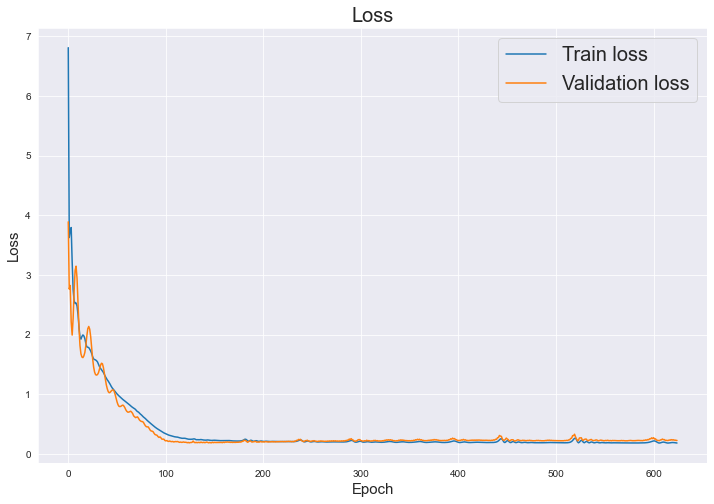

In [29]:
# obtain train losses from all epochs
history = net.history
train_loss_log=history[:, 'train_loss']
val_loss_log=history[:, 'valid_loss']

# Plot losses
plt.figure(figsize=(12,8))
plt.plot(train_loss_log)
plt.plot(val_loss_log)
plt.title('Loss', fontsize = 20)
plt.xlabel('Epoch', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.legend(['Train loss', 'Validation loss'], loc='best', fontsize = 20)
plt.savefig("regularization_Losses.png")
plt.show()

#### Properties of the net

In [ ]:
y_pred = net.predict(X_test)
y_pred = torch.from_numpy(y_pred).float()

In [ ]:
#Plot Test points vs Prdicted points
zipped_lists = zip(X_test, y_pred)
sorted_pairs = sorted(zipped_lists)

tuples = zip(*sorted_pairs)
X, y = [ list(tuple) for tuple in  tuples]

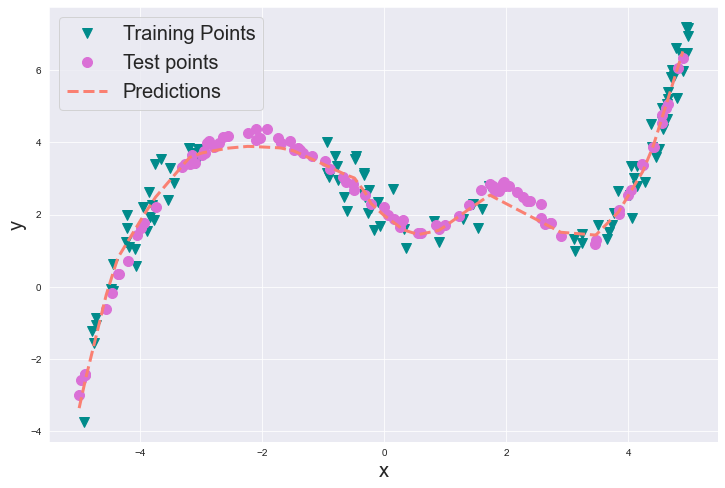

In [100]:
plt.figure(figsize=(12,8))
plt.plot(X_train, y_train, color = 'darkcyan', label = 'Training Points', marker = 'v', ls='', markersize =10) 
plt.plot(X_test, y_test, color='orchid', ls='', marker='.', markersize =20, label = 'Test points')
plt.plot(X, y, color='salmon', ls='--', label='Predictions',linewidth =3)
plt.xlabel('x', fontsize = 20)
plt.ylabel('y', fontsize = 20)
plt.legend(loc='best', fontsize = 20)
plt.savefig("Predictions.png", dpi=400)
plt.show()

### Metrics

In [53]:
#Train Loss
train_loss=train_loss_log[-1]

#Val loss
val_loss=val_loss_log[-1]

#get the losses
print("Train Loss:\t",round(train_loss,3))
print("Val Loss:\t",round(val_loss,3))
print("Test Loss:\t",round(float(test_loss),3))

Train Loss:	 0.183
Val Loss:	 0.227
Test Loss:	 0.068


In [56]:
#Saving the whole model
import pickle
with open("models.pkl", 'wb') as f:
    pickle.dump(net, f)

### Weight histograms and activation profiles

In [58]:
#Access network parameters
net = net.module_

In [59]:
#Acces network parameters
# First hidden layer
h1_w = net.fc1.weight.data.cpu().numpy()
h1_b = net.fc1.bias.data.cpu().numpy()

# Second hidden layer
h2_w = net.fc2.weight.data.cpu().numpy()
h2_b = net.fc2.bias.data.cpu().numpy()

# Output layer
out_w = net.out.weight.data.cpu().numpy()
out_b = net.out.bias.data.cpu().numpy()

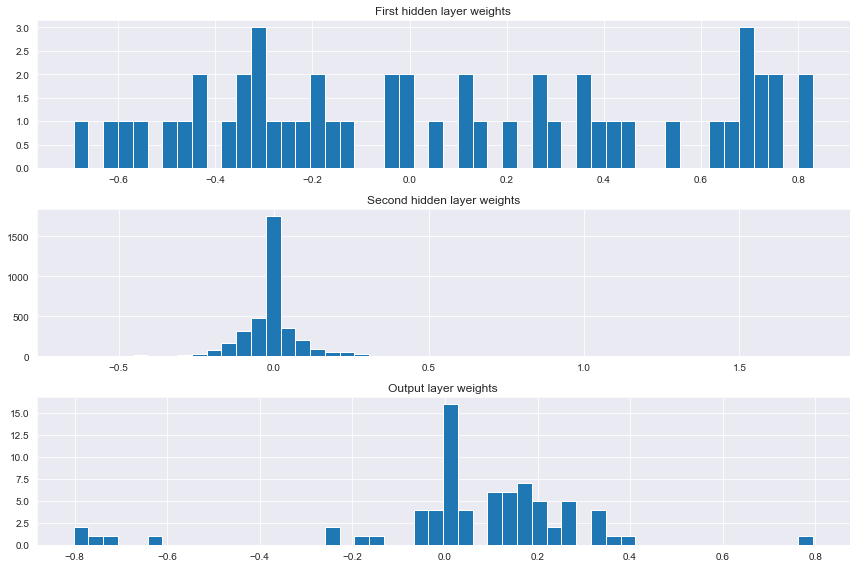

In [62]:
#weights histograms
fig, axs = plt.subplots(3, 1, figsize=(12,8))
axs[0].hist(h1_w.flatten(), 50)
axs[0].set_title('First hidden layer weights')
axs[1].hist(h2_w.flatten(), 50)
axs[1].set_title('Second hidden layer weights')
axs[2].hist(out_w.flatten(), 50)
axs[2].set_title('Output layer weights')
plt.tight_layout()
plt.show()

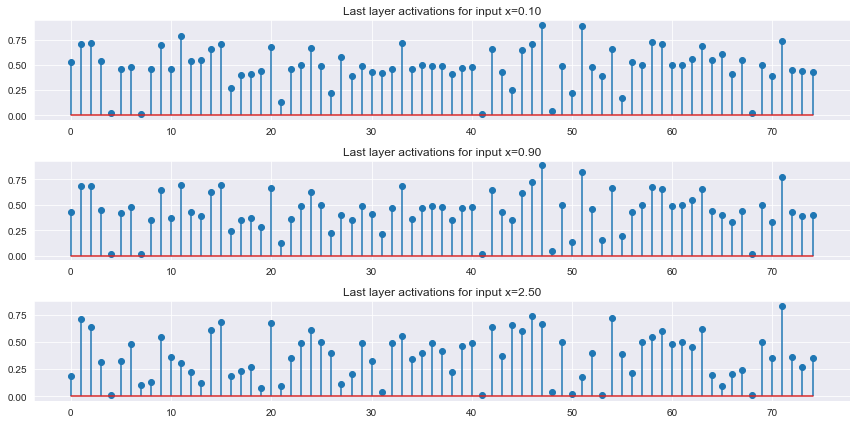

In [64]:
#analize activataion
def get_activation(layer, input, output):
    global activation
    activation = torch.sigmoid(output)

### Register hook  
hook_handle = net.fc2.register_forward_hook(get_activation)

### Analyze activations
net = net.to(device)
net.eval()
with torch.no_grad():
    x1 = torch.tensor([0.1]).float().to(device)
    y1 = net(x1)
    z1 = activation
    x2 = torch.tensor([0.9]).float().to(device)
    y2 = net(x2)
    z2 = activation
    x3 = torch.tensor([2.5]).float().to(device)
    y3 = net(x3)
    z3 = activation

### Remove hook
hook_handle.remove()

### Plot activations
fig, axs = plt.subplots(3, 1, figsize=(12,6))
axs[0].stem(z1.cpu().numpy(), use_line_collection=True)
axs[0].set_title('Last layer activations for input x=%.2f' % x1)
axs[1].stem(z2.cpu().numpy(), use_line_collection=True)
axs[1].set_title('Last layer activations for input x=%.2f' % x2)
axs[2].stem(z3.cpu().numpy(), use_line_collection=True)
axs[2].set_title('Last layer activations for input x=%.2f' % x3)
plt.tight_layout()
plt.show()